### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

#### Loading Data and assigning 80% of data as training set and remaining 20% as test set.

In [2]:
data = pd.read_csv('../input/creditcardfraud/creditcard.csv')
# credit_card = data.sample(int((data.shape[0]*0.8)//1), random_state = 0)
credit_card = data.head(int((data.shape[0]*0.8)//1))
credit_card_test = data.tail(int((data.shape[0]*0.2)//1))

In [3]:
fraud = pd.DataFrame([credit_card.loc[i] for i in range(credit_card.shape[0]) if credit_card.loc[i]['Class'] == 1])
non_fraud = pd.DataFrame([credit_card.loc[i] for i in range(credit_card.shape[0]) if credit_card.loc[i]['Class'] == 0])

In [4]:
X, y = credit_card.drop(["Class"], axis=1), credit_card['Class']
X

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227840,145244.0,2.028950,-0.374089,-1.268051,0.349127,-0.057977,-0.515489,-0.087045,-0.146316,1.001341,...,-0.194318,0.047287,0.323331,0.080683,0.727965,0.070118,0.723291,-0.083032,-0.061277,24.95
227841,145245.0,0.306600,1.116021,-0.047348,3.593785,2.079047,5.748707,-2.059246,-1.352120,-1.849240,...,0.865457,-1.458527,-0.234478,0.258831,0.639005,-0.048250,0.144586,0.216385,0.304545,0.76
227842,145245.0,-1.781954,2.062680,-3.758871,-1.801001,-0.084365,1.919610,-1.454364,-9.825473,-2.073119,...,-0.690810,1.234747,0.376804,-0.339706,-0.216688,-1.555393,0.655873,0.777662,0.272753,359.28
227843,145245.0,-0.061507,1.024900,-0.170060,-0.263220,0.982164,-1.162749,1.468942,-0.648407,-0.157586,...,0.035225,0.299618,1.177722,-0.296209,-0.140335,-0.465171,-0.197933,-0.048916,0.023871,39.40


In [5]:
non_fraud.shape

(227428, 31)

#### Observation

As it is clear that data is highly unbalanced, out of 227845 total transactions in our training set, 227428 are non-fraud. So I will apply Random Over Sampling on the fraud transactions data, so as to remove the imbalance in data.

An important thing to note here is that we could have also done undersampling on non-fraud data but that would have reduced the number of data points by a great margin and our model would become underfit for sure. Over sampling may lead to over-fitting, but due to the large number of features here, it is unlikely. Hence we apply Oversampling Method.

### Balancing the data by Oversampling

In [6]:
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X,y)

In [7]:
X_resampled = (X_resampled-X_resampled.min())/(X_resampled.max()-X_resampled.min())

In [8]:
resampled_train = pd.concat([X_resampled,y_resampled],axis=1)

### Selecting the useful features from Data

I use correlation matrix to look at how target column is responding to the features using a seaborn plot and create a rough picture of which features are useful. 

Then I use SelectKBest to get contribution score of every feature. From both these observations, I decide which features to pick. I generally give SelectKBest more importance because in Correlation matrix features are interrelated and hence get same 'importance' from target column but SelectKBest takes a note of their interrelation.

In [9]:
sns.set(rc={'figure.figsize':(25,21)})

<AxesSubplot:>

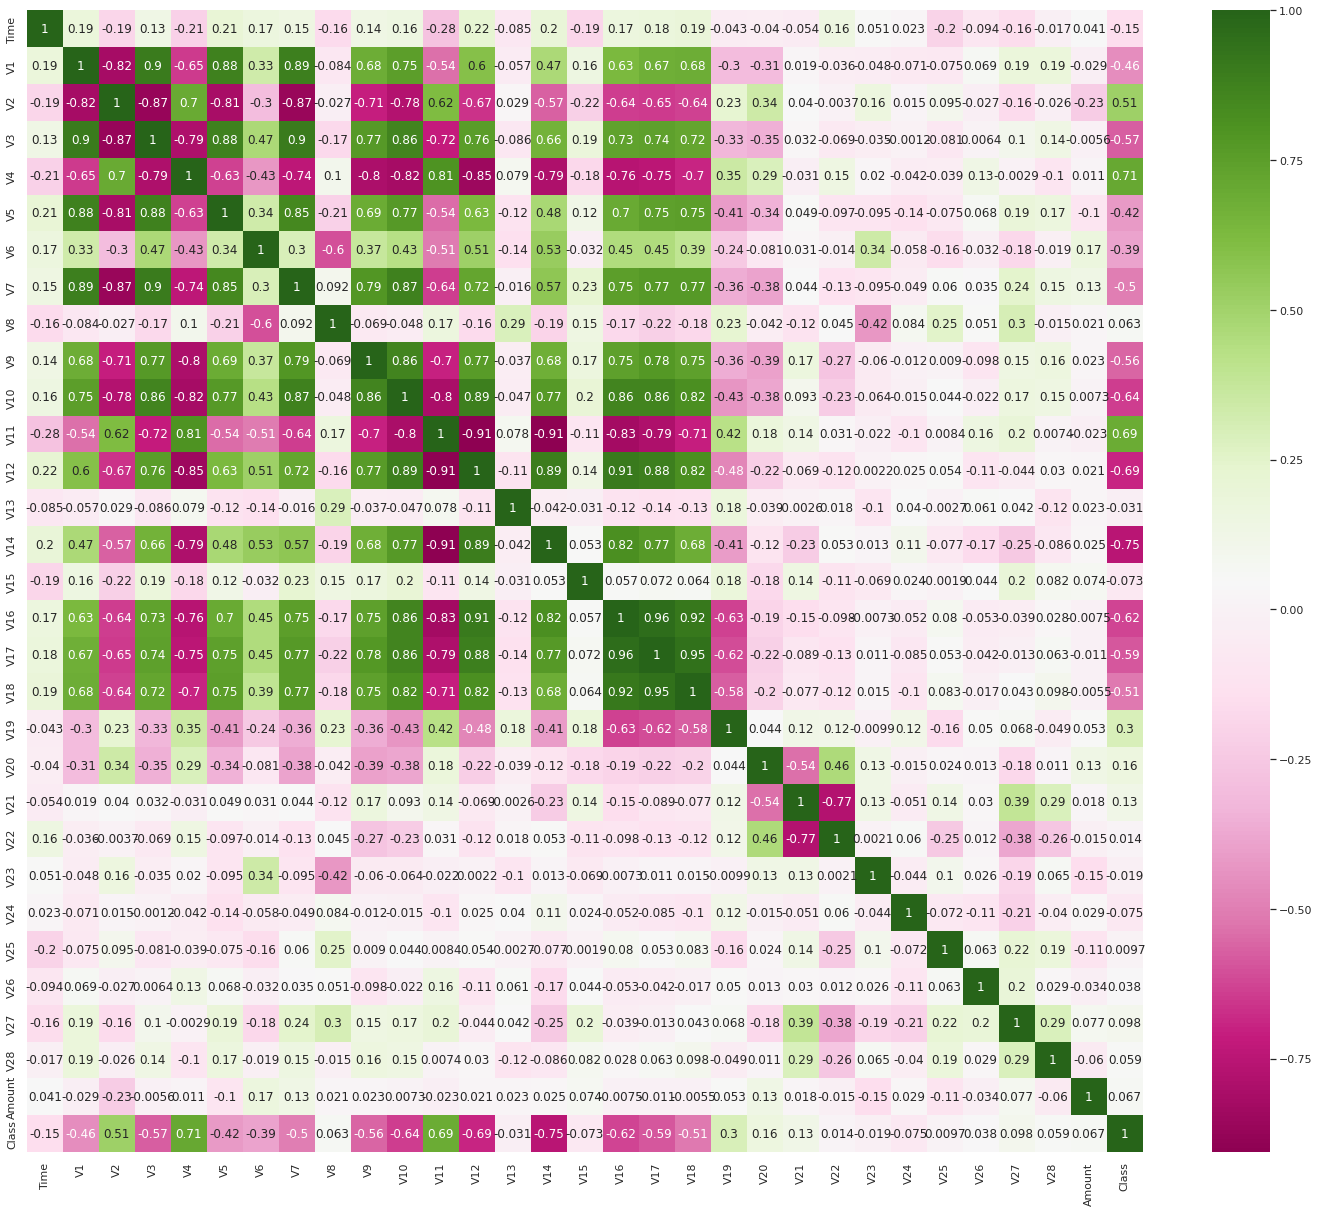

In [10]:
sns.heatmap(resampled_train.corr(), cmap = 'PiYG', annot=True)

In [11]:
select = SelectKBest(chi2, k='all')
select.fit_transform(X_resampled, y_resampled)
scores = select.scores_

In [12]:
scores_dict = {}
for i in range(len(scores)):
    scores_dict[X_resampled.columns[i]] = scores[i]
    
score_dict_sorted = {k:v for k,v in sorted(scores_dict.items(), key= lambda x: x[1], reverse=True)}    

In [13]:
score_dict_sorted

{'V11': 15664.676906520377,
 'V4': 13407.7837574771,
 'V12': 12409.226907424236,
 'V14': 12191.295577791669,
 'V16': 8948.225525177771,
 'V17': 8597.238366222355,
 'V18': 6333.971184201753,
 'V3': 5156.963903481548,
 'V10': 4139.420581343615,
 'V9': 2375.8280291257593,
 'Time': 1468.3793482979802,
 'V7': 1373.1120656190042,
 'V1': 1023.973187318203,
 'V19': 702.7725497962078,
 'V5': 509.8368148871847,
 'V2': 255.30916832172505,
 'V6': 178.01824187299013,
 'Amount': 62.52290655308575,
 'V15': 52.10545367912849,
 'V24': 42.587401907944624,
 'V21': 31.746008747337456,
 'V26': 9.01386415109707,
 'V13': 8.657229146081388,
 'V20': 8.10289389285341,
 'V8': 7.309837848520507,
 'V27': 6.226008028795475,
 'V28': 0.6472382504055598,
 'V22': 0.6171562473173382,
 'V25': 0.11117936795898423,
 'V23': 0.0977663787916224}

In [14]:
features = [k for k,v in score_dict_sorted.items() if v > 2000]

In [15]:
features

['V11', 'V4', 'V12', 'V14', 'V16', 'V17', 'V18', 'V3', 'V10', 'V9']

### Creating the final Training and Test sets 

In [16]:
X_train = X_resampled[features]
y_train = y_resampled

In [17]:
X_test = credit_card_test.drop(['Class'],axis=1)[features]
X_test = (X_test-X_test.min())/(X_test.max()-X_test.min())
y_test = credit_card_test['Class']

### In order to compare performance, I have used three famous classifiers from sklearn 

1. Decision Tree
2. Random Forest
3. Extra Trees

I compare them in three different ways:
1. How good is their precision-recall graph?
2. How much is their area under ROC (Receiver Operating Characteristic) curve i.e., a curve of True Positives and False positives.
3. Accuracy : How many values were guessed wrong? 

I have **not used XGBoost** here but might compare it too in the future.

**P.S. You can read the explanation for these results at the end of this file.**

In [18]:
classifier1 = DecisionTreeClassifier(min_samples_split = 2)
classifier2 = RandomForestClassifier(n_estimators=500, min_samples_split = 2, verbose=1, )
classifier3 = ExtraTreesClassifier(n_estimators=500, min_samples_split = 2, verbose=1, )

In [19]:
classifier1.fit(X_train, y_train)

DecisionTreeClassifier()

In [20]:
y_pred1 = classifier1.predict(X_test)

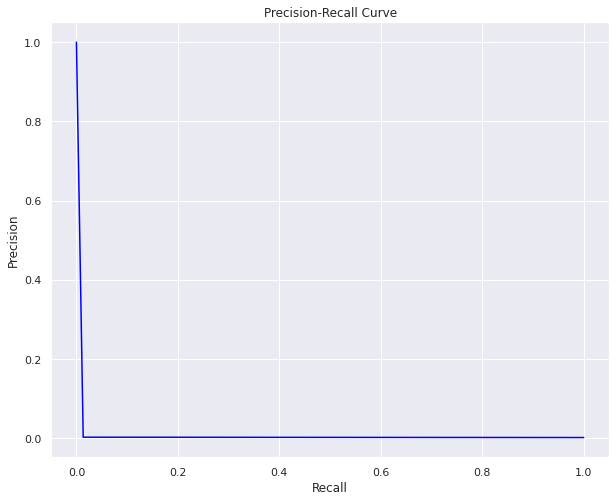

In [21]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred1)
sns.set(rc={'figure.figsize':(10,8)})
fig, ax = plt.subplots()
ax.plot(recall, precision, color = 'blue')
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show()

In [22]:
classifier2.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  8.9min finished


RandomForestClassifier(n_estimators=500, verbose=1)

In [23]:
y_pred2 = classifier2.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.0s finished


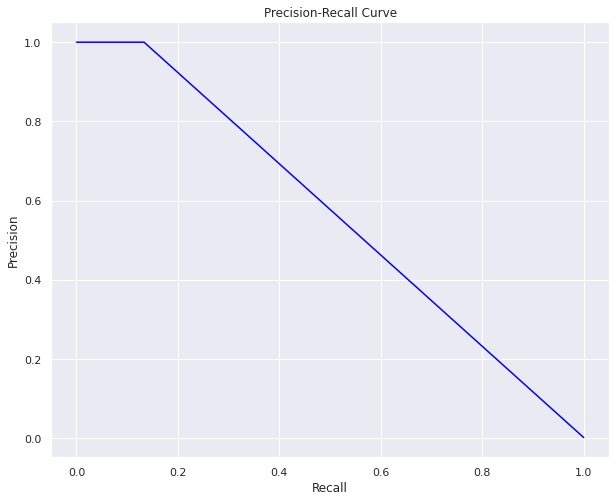

In [24]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred2)
sns.set(rc={'figure.figsize':(10,8)})
fig, ax = plt.subplots()
ax.plot(recall, precision, color = 'blue')
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show()

In [25]:
classifier3.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.0min finished


ExtraTreesClassifier(n_estimators=500, verbose=1)

In [26]:
y_pred3 = classifier3.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.2s finished


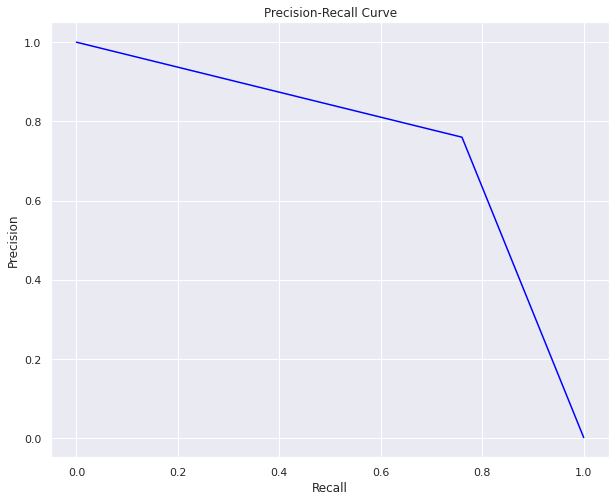

In [27]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred3)
sns.set(rc={'figure.figsize':(10,8)})
fig, ax = plt.subplots()
ax.plot(recall, precision, color = 'blue')
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show()

In [28]:
score1 = roc_auc_score(y_test, y_pred1)
score2 = roc_auc_score(y_test, y_pred2)
score3 = roc_auc_score(y_test, y_pred3)

In [29]:
score1, score2, score3

(0.5025619660373378, 0.5666666666666667, 0.8798417888408396)

In [30]:
sum(abs(y_test-y_pred1))*100/y_test.shape[0], sum(abs(y_test-y_pred2))*100/y_test.shape[0] , sum(abs(y_test-y_pred3))*100/y_test.shape[0]

(0.9497726514632819, 0.11411316514808377, 0.06320113762047717)

## Observations :
1. Precision-Recall graph is very poor for Decision Tree, average for Random Forest and Good for Extra Trees.
2. AUC of ROC curve is very low for Decision Tree, low  for Random Forest and High for Extra Trees.
3. The accuracies are:
    1. **99.05%** for Decision Tree
    2. **99.886%** for Random Forest
    3. **99.937%** for Extra Trees

## Neural Network Model

I have also tried it on a neural network, built on keras.Sequential with 4 layers in total.

In [31]:
model = keras.Sequential([
    keras.layers.Dense(20,input_shape=(10,), activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.fit(X_train, y_train, epochs=15)

2022-07-17 13:59:51.939157: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-17 13:59:52.233417: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
14215/14215 [==============================] - 26s 2ms/step - loss: 0.1737 - accuracy: 0.9371
Epoch 2/15
14215/14215 [==============================] - 26s 2ms/step - loss: 0.1573 - accuracy: 0.9413
Epoch 3/15
14215/14215 [==============================] - 26s 2ms/step - loss: 0.1478 - accuracy: 0.9446
Epoch 4/15
14215/14215 [==============================] - 26s 2ms/step - loss: 0.1418 - accuracy: 0.9458
Epoch 5/15
14215/14215 [==============================] - 26s 2ms/step - loss: 0.1365 - accuracy: 0.9475
Epoch 6/15
14215/14215 [==============================] - 26s 2ms/step - loss: 0.1309 - accuracy: 0.9483
Epoch 7/15
14215/14215 [==============================] - 25s 2ms/step - loss: 0.1242 - accuracy: 0.9499
Epoch 8/15
14215/14215 [==============================] - 26s 2ms/step - loss: 0.1177 - accuracy: 0.9520
Epoch 9/15
14215/14215 [==============================] - 26s 2ms/step - loss: 0.1129 - accuracy: 0.9541
Epoch 10/15
14215/14215 [==============================

In [32]:
pred= model.predict(X_test)

In [33]:
prediction = []
for i in pred:
    if i >= 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
prediction = np.array(prediction)        

In [34]:
100-sum(abs(y_test-prediction))*100/y_test.shape[0]

96.96458980706097

In [35]:
model.evaluate(X_test, y_test)

1781/1781 [==============================] - 3s 1ms/step - loss: 0.1613 - accuracy: 0.9696


[0.16126856207847595, 0.9696459174156189]

### Neural Network Results

Neural Network returns a Test Accuracy of **96.96%** which is not bad at all considering the simple architecture of Neural Network. 
P.S. I have not explained the result and concept of Neural Networks here because it is a big topic.

<br>

# Explanation for 3 classification models
<br>

1. **Decision Tree** is a very intuitive model where we try to find the best condition for splitting the data. We Split the data at every branch of the tree after a condition is followed with a Yes/No criterion. Finally, after all the splits we get distinguished groups of all the classes.
<br>

2. In a **Random Forest**, as the name suggests, we use a lot of trees. Every tree takes some amount of features and gives its prediction for **that** data only. The trees are tried to be kept as much uncorrelated to each other as possible and finally the majority of predictions of all the trees is taken as the final answer.
<br>

3. In **Extra (Randomized) Trees**, the concept is very similar to Random Forest, but there are two differences. 
    1. We take the complete training data for a feature in every tree in Extra Trees and do not use Bootstrapping as in Random Forest.
    2. We do not take the best split, but we select the best split from the randomly selected split from the current tree in Extra Trees but in Random Forest we find the best split at every branch in a tree.
   Due to such kind of splitting, there is even more randomness in Extra Trees model. 
<br>



### Why did we get the results we got?

1. Decision Tree uses a single tree and runs once in it to find the class, but Random Forest reduces variance by randomization and running over more and more trees develops even higher accuracy. It is far more robust towards change in data or noise than a single Decision Tree.
<br>

2. Extra Trees performing better in our case might be due to the large amount of data we are using and only 10 features using for training. There might some variance in Random Forest which gets reduced in Extra Trees Classifier. 